# Azure Connection for the data base.


## issue: Blobs DB does not have an inherent indices system.

In [1]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__
import os
from datetime import datetime
import time
import shutil
import cv2
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import glob,re
from itertools import combinations

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
local_dir = './d1'

if not os.path.exists(local_dir): os.makedirs(local_dir)

In [4]:
shutil.rmtree(local_dir) #delete directory

In [4]:
# Azure connecting info. 
os.environ['AZURE_STORAGE_CONNECTION_STRING'] = 'DefaultEndpointsProtocol=https;AccountName=blobsdb;AccountKey=tJK43kihAcaeZMjcegWFcyg8tsFmOr9f2Kn8q6NUinVSJW5O3jymYbjaiGBjmx8Ibq5LsBVPcABvYeV+tUCPnQ==;EndpointSuffix=core.windows.net'
connect_str = os.getenv('AZURE_STORAGE_CONNECTION_STRING')
# Create the BlobServiceClient object which will be used to create a container client.
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

In [5]:
def retrieve_last_k_containers(k):
    
    "function retrieve last k containers from Azure Blobs Storage"

    container_list=[]
    # list containers
    for i,item in enumerate(reversed(list(blob_service_client.list_containers()))):
        print(datetime.fromtimestamp(int(item["name"].split("-")[0])))
        container_list.append(item["name"])
        if i ==k:
            break
    return container_list

In [6]:
container_list=retrieve_last_k_containers(5)

2021-11-30 18:00:59
2021-11-30 17:44:00
2021-11-30 17:27:01
2021-11-30 17:10:03
2021-11-30 16:53:04
2021-11-30 16:37:23


# Download files - blobs

In [8]:
def dl_blobs_to_local(container_list):
    for container in container_list:
        dir_name = local_dir + "/" + container
        os.makedirs(dir_name)
        container_client = blob_service_client.get_container_client(container)
        for blob in container_client.list_blobs():
            save_blob(blob.name,dir_name,container_client)
            
            
def save_blob(blob_name,dir_name,container_client):
    
    "function downloads and saves one blob"
    
    with open(dir_name+"/"+ str(blob_name), "wb") as my_blob:
        blob_client = container_client.get_blob_client(blob_name) # Instantiate a new BlobClient
        download_stream = blob_client.download_blob()
        my_blob.write(download_stream.readall())

In [9]:
#shutil.rmtree(local_dir) #delete directory

In [10]:
dl_blobs_to_local(container_list) # download

# Masking 
## how to mask raspberry camera input:

A.Pre Defined masking - Not good because every change in the setup requires retuning of the masking parameters. 

B. Masking by motion detection, using image substraction, this approach we try here below.

C. NN that object detect the desired object in the picture and set boundaries. 

## original masking function (option A)

In [7]:
def mask_images(img_path, erode_func, output_lib, params, output_ext=".jpg"):
   

    """:param img_path: string, path to the image.
       :param erode_func: function, masking function.
       :param output_lib: string, path to output directory.
       :param output_ext: string, type of output image, default jpg.
       :param params: dictionary mask- parameters.

       :returns np.arrays of g_img, mask_g and img

       """

    # set cropping and masking parameters:
    hlc, hrc, vlc, vuc = params["hlc"], params["hrc"], params["vlc"], params["vuc"]
    n, n_iter = params["n"], params["n_iter"]

    # extract img name:
    img_name = os.path.splitext(Path(img_path).name)[0]

    # output name
    g_img_path = output_lib + '/' + 'gr_' + img_name + output_ext  # output path to g_img

    img = cv2.imread(img_path)[vlc:vuc, hlc:hrc]  # cv2 read & crop
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # convert to hsv
    mask = cv2.inRange(hsv, (35, 25, 25), (80, 255, 255))  # mask by slicing the green spectrum
    # mask = cv2.inRange(hsv, (0, 42, 0), (179, 255, 255)) # everything except white

    # apply the masking:
    imask = mask > 0
    g_img = np.zeros_like(img, np.uint8)
    mask_g = np.zeros_like(img, np.uint8)

    # make white background
    g_img.fill(255)
    g_img[imask] = img[imask]
    mask_g[~imask] = img[~ imask]
    mask_g[mask_g != 0] = 255

    # erosion
    g_img, mask, img = erode_func(img, mask_g, n, n_iter)

    # save to directory
    cv2.imwrite(g_img_path, g_img)

    return g_img, mask, img

# Motion Detection (option A)

In [8]:
img1 = "./d1/1638287584-302754/56img0-90.jpg"
img2 = "./d1/1638287584-302754/56img2-38.jpg"
img3 = "./d1/1638287584-302754/56img4-38.jpg"

In [9]:
im1 = cv2.imread(img1)
im2 = cv2.imread(img2)
im3 = cv2.imread(img3)

In [10]:
im1_np = np.int32(im1)
im2_np = np.int32(im2)
im3_np = np.int32(im3)

im13_np=cv2.subtract(im1_np,im3_np)
im23_np=cv2.subtract(im2_np,im3_np)
im12_np=cv2.subtract(im1_np,im2_np)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


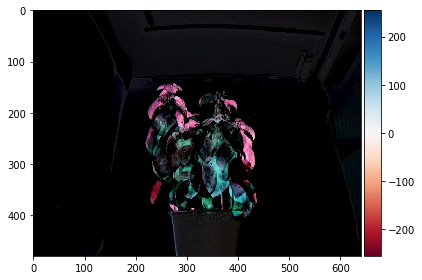

In [11]:
imshow(im23_np)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


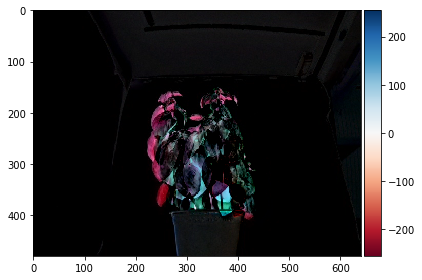

In [12]:
imshow(im12_np)

In [13]:
gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
gray3 = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)

gray12=cv2.subtract(gray1,gray2)
gray13=cv2.subtract(gray1,gray3)
gray23=cv2.subtract(gray2,gray3)

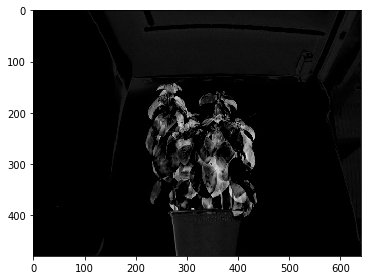

In [14]:
imshow(gray23)

In [15]:
def derivative(series, interval=1):
    """interval-lag auxiliary
        :parameters: 
                    dataset (DataFrame)
                    intervel (int)
        :returns: 
                    DataFrame of (intervel)-Lag."""
    
    diff = list()
    for i in range(len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)
    return np.array(diff)


def find_crop_indices(img_diff):

    
    def find_turning_pts(M,interval):
    
        left=[]
        right=[]
    
        for t in range(interval,len(M)):
            if M[t] != 0:
                for j in range(1,interval+1):
                    if M[t-j] !=0:
                        break
                if j == interval:
                    left.append(t)
                
                
        for t in range(0, len(M)-interval):
            if M[t] != 0:
                for j in range(1,interval+1):
                    if M[t+j] !=0:
                        break
                if j == interval:
                    right.append(t)
        return [0]+left+[len(M)],[0]+right+[len(M)]
    
    #reduce img to vertical mean vector
    M = img_diff.mean(axis=0)
    
    #compute median for clipping
    M_median = (M.max()-M.min())/2
    
    #aux clipper
    clip = lambda t : 0 if t-M_median < 0 else t 
    
    #apply on mean vec on M
    M_mod = np.array([clip(t) for t in M])
    
    #find suspected points for the main objects' boundaries
    right,left = find_turning_pts(abs(derivative(M_mod)),50) 
    
    #compute the biggest component 
    ind_max=np.argmax(list(map(int.__sub__, left, right)))
    
    # safety intervel to be added
    M_safe=100
    crop_interval= (max(0,right[ind_max]-M_safe),min(len(M_mod),left[ind_max]+M_safe)) 
    
    hlc,hrc = crop_interval
    return hlc,hrc
    

In [16]:
find_crop_indices(gray23)

(147, 528)

In [71]:
M=gray23.mean(axis=0)

In [72]:
M_median=(M.max()-M.min())/2

In [73]:
crop = lambda t : 0 if t-M_median < 0 else t

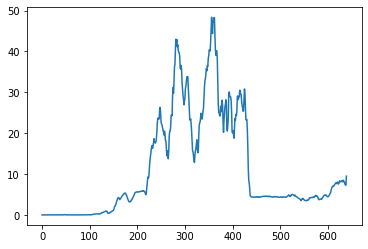

In [74]:
plt.plot(M)

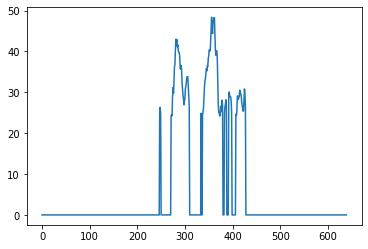

In [75]:
M_mod = np.array([crop(t) for t in M])
plt.plot(M_mod)

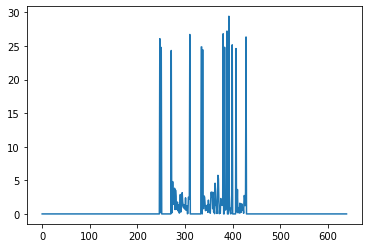

In [77]:
plt.plot(abs(derivative(M_mod)))

In [78]:
def find_turning_pts(M,interval):
    
    left=[]
    right=[]
    
    for t in range(interval,len(M)):
        if M[t] != 0:
            for j in range(1,interval+1):
                if M[t-j] !=0:
                    break
            if j == interval:
                left.append(t)
                
                
                
    for t in range(0, len(M)-interval):
        if M[t] != 0:
            for j in range(1,interval+1):
                if M[t+j] !=0:
                    break
            if j == interval:
                right.append(t)
    
    
    return [0]+left+[len(M)],[0]+right+[len(M)]


In [79]:
right,left=find_turning_pts(abs(derivative(M_mod)),50)

In [80]:
moving_int_size=list(map(int.__sub__, left, right))

In [81]:
moving_int_size

[0, 181, 0]

In [82]:
ind_max=np.argmax(moving_int_size)

In [83]:
M=100

In [84]:
crop_interval= (max(0,right[ind_max]-M),min(len(M_mod),left[ind_max]+M)) 

In [85]:
crop_interval

(147, 528)

In [42]:
hlc,hrc = crop_interval

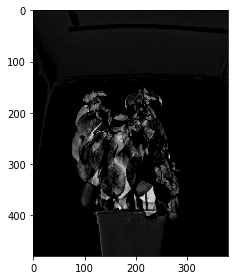

In [43]:
imshow(gray12[:, hlc:hrc])

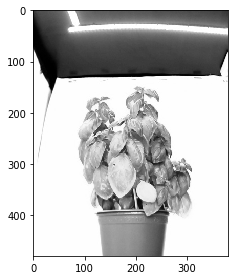

In [44]:
imshow(gray1[:, hlc:hrc])

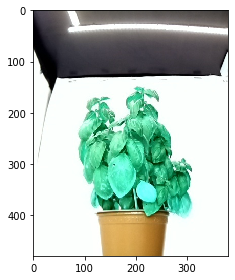

In [45]:
imshow(im1[:, hlc:hrc])

In [46]:
container_path = "./d1/1638288603-002925"

def organize_container(container_path):
    
    
    files = [file.split("/")[-1] for file in glob.glob(container_path+"/*")]
    cameras = list(set([file[0:2] for file in files]))
    d={}
    # dict init
    for cam in cameras:
        d[cam]=[]
    for file in files:
        d[file[0:2]].append(container_path+"/"+file)
    
    return d

In [47]:
d = organize_container(container_path)

In [86]:
def crop_session(d):
    
    cameras = list(d.keys())
    d_grey={}
    
    for cam in cameras:
        grey=[]
        for img in d[cam]:
            grey.append(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY))
        d_grey[cam] = grey
        
    
    d_grey_diff = {}
    for cam in cameras:  
        grey = d_grey[cam]
        diff_img_inds = [(x,x+1) for x in range(len(grey)-1)]
        d_grey_diff[cam]=[]
        for tup in diff_img_inds:
            i,j = tup
            d_grey_diff[cam].append(cv2.subtract(grey[j],grey[i]))
    return  d_grey_diff

In [87]:
d_grey_diff=crop_session(d)

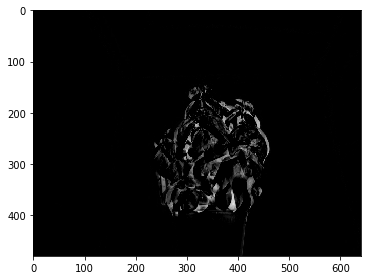

In [88]:
imshow(d_grey_diff["56"][2])

# COLMAP

array([   0,    0,    0, ..., 7315, 6355, 8098], dtype=uint64)